In [1]:
import gzip
from xml.dom import minidom
from utils.list_files import get_stem
import os
import json
from utils.imutil import imshow
import numpy as np

In [2]:
with gzip.open('data/Siren_063021_NoPec_MoreReverb_SideEntrance+Lighting.als') as f:
    raw = minidom.parseString(f.read())
    
def get_attribute(elt, attrib_name):
    return elt.attributes[attrib_name].value
    
def get_tag_attribute(elt, tag_name, attrib_name):
    target = elt
    for e in tag_name.split('/'):
        target = target.getElementsByTagName(e)[0]
    return get_attribute(target, attrib_name)

In [3]:
tempo = float(get_tag_attribute(raw, 'Tempo/Manual', 'Value'))
seconds_per_beat = 60 / tempo

In [4]:
# get all arranger audio clips and flatten 
all_automation = raw.getElementsByTagName('ArrangerAutomation')
audio_clips = [e.getElementsByTagName('AudioClip') for e in all_automation]
audio_clips = [e for l in audio_clips for e in l]

In [5]:
offsets = []

for audio_clip in audio_clips:
    try:
        # live 10
        filename = get_tag_attribute(audio_clip, 'FileRef/Name', 'Value')
    except:
        # live 11
        filename = get_tag_attribute(audio_clip, 'FileRef/RelativePath', 'Value')
        _, filename = os.path.split(filename)
    start = get_tag_attribute(audio_clip, 'CurrentStart', 'Value')
    start = float(start) * seconds_per_beat # beats
    end = get_tag_attribute(audio_clip, 'CurrentEnd', 'Value')
    end = float(end) * seconds_per_beat # beats
    loop_start = get_tag_attribute(audio_clip, 'LoopStart', 'Value')
    loop_start = float(loop_start) # seconds
    
    # patch this filename with the other, which is offset
    if filename == '022619_Solo with Shrimp_Bass_mcq_02-28-20_Start Theme 1.wav':
        filename = '022619_Solo with Shrimp_Bass_mcq_02-28-20.wav'
        loop_start += 7 * 60 + 4 # 7m4s from start of original
        
    offsets.append((filename, loop_start, start, end))
    
# dedupe to remove overlapping tracks
offsets = list(set(offsets))

offsets_export = [
    {
        'stem': get_stem(filename),
        'loop_start': loop_start,
        'start': start,
        'end': end
    } for filename, loop_start, start, end in offsets]

In [6]:
with open('data/ableton_analysis.json', 'w') as f:
    json.dump(offsets_export, f)

In [7]:
output_framerate = 60

In [8]:
sr = 44100
hop_length = 512
feature_framerate = sr / hop_length
feature_framerate

86.1328125

In [9]:
def is_annotated(stem):
    annotation_fn = f'data/{stem}.Table.1.selections.txt'
    return os.path.exists(annotation_fn)

In [10]:
import pickle
def load_cache(name):
    with open(f'cache/{name}.pkl', 'rb') as f:
        return pickle.load(f)
grouped = load_cache('grouped')

In [49]:
end_time = max([e[-1] for e in offsets])
max_index = int(end_time * output_framerate)

full_pts = np.zeros((max_index, 2))
full_units = [''] * max_index

good = 0
out_of_bounds = 0

for audio_fn, loop_start, start, end in offsets:
    stem = get_stem(audio_fn)
    if not is_annotated(stem):
        continue
    print('using', stem)
    pts = grouped[stem]['embed_amp_per_unit_2d']
    units = grouped[stem]['units']
    
    start_index = int(start * output_framerate)
    end_index = int(end * output_framerate)
    
    for i in range(start_index, end_index):
        t = (i - start_index) / output_framerate
        t += loop_start
        j = int(t * feature_framerate)
        
        try:
            full_pts[i] = pts[j]
            full_units[i] = units[j]
            good += 1
        except:
            out_of_bounds += 1

print('good', good, 'out of bounds', out_of_bounds)

using 022619_Solo with Shrimp_Bass_mcq_02-28-20
using 022219_Mono-003_Flutter_Penultimate_mcq_021420
using 022319_Mono-001_Amazing_Solo_HPF-12_mcq013120
good 115830 out of bounds 59


In [12]:
import json
with open('dump.json', 'w') as f:
    quantized = (full_pts * 255).astype(np.uint8)
    json.dump(list(zip([(a.item(),b.item()) for a,b, in quantized], full_units)), f, separators=(',', ':'))

In [61]:
# should probably move the color code to this notebook
# and maybe even split the ableton parsing from the design preparation?

# run this code once with "True" and once with "False"
# to get the annotated and unannotated versions
use_annotated = False

settings = json.load(open('settings.json'))
global_lights = settings['global_lights']
local_lights = settings['local_lights']

n_lights = global_lights + local_lights
color_channels = 3

end_time = max([e[-1] for e in offsets])
max_index = int(end_time * output_framerate)
full_design = np.zeros((max_index, n_lights, color_channels))

good = 0
out_of_bounds = 0

for audio_fn, loop_start, start, end in offsets:
    stem = get_stem(audio_fn)
#     print(stem)

    if use_annotated != 'both' and is_annotated(stem) != use_annotated:
        print('skipping', stem)
        continue
    print('using', stem)
    
    design_fn = f'design/{stem}.npy'
    if not os.path.exists(design_fn):
        print(start, end, 'skipping', stem)
        continue

    design = np.load(design_fn)
    
    start_index = int(start * output_framerate)
    end_index = int(end * output_framerate)
    
#     t_end = (end_index - start_index) / output_framerate
#     t_end += loop_start
#     j = int(t * feature_framerate)
#     print('t_end', t_end, 'j', j)
    
    # this uses a nearest neighbor interpolation
    # but we could use another technique for rescaling
    for i in range(start_index, end_index):
        t = (i - start_index) / output_framerate
        t += loop_start
        j = int(t * feature_framerate)
        
        try:
            full_design[i] += design[j]
            good += 1
        except:
            out_of_bounds += 1
        
print()
print('max', full_design.max())
print('good', good, 'out of bounds', out_of_bounds)

dmx = (np.clip(full_design, 0, 1) * 255).astype(int)

output = {
    'framerate': output_framerate,
    'data': dmx.tolist()
}

if use_annotated == 'both':
    description = ''
else:
    description = '-annotated' if use_annotated else '-unannotated'
fn = f'data/design{description}.json'
print('saving', fn)
with open(fn, 'w') as f:
    json.dump(output, f, separators=(',',':'))#, indent=2)

print('done')

using FULL_Background_mcq021420
using Pec Slaps Cleaned Up
skipping 022619_Solo with Shrimp_Bass_mcq_02-28-20
skipping 022219_Mono-003_Flutter_Penultimate_mcq_021420
skipping 022319_Mono-001_Amazing_Solo_HPF-12_mcq013120
using Pec Slaps Cleaned Up
using BEST_Whale Duet_Bass_EQ_mcq013120
using BEST_Whale Duet_Bass_EQ_mcq013120

max 2.3279960859326745
good 214039 out of bounds 0
saving data/design-unannotated.json
done


In [62]:
h,w,c = dmx.shape

In [75]:
cols = 1024
rows = int(np.ceil(h / cols))
img = np.zeros((rows * cols, w, 3), np.uint8)

In [76]:
img[:len(dmx)] = dmx[:,:,:3]

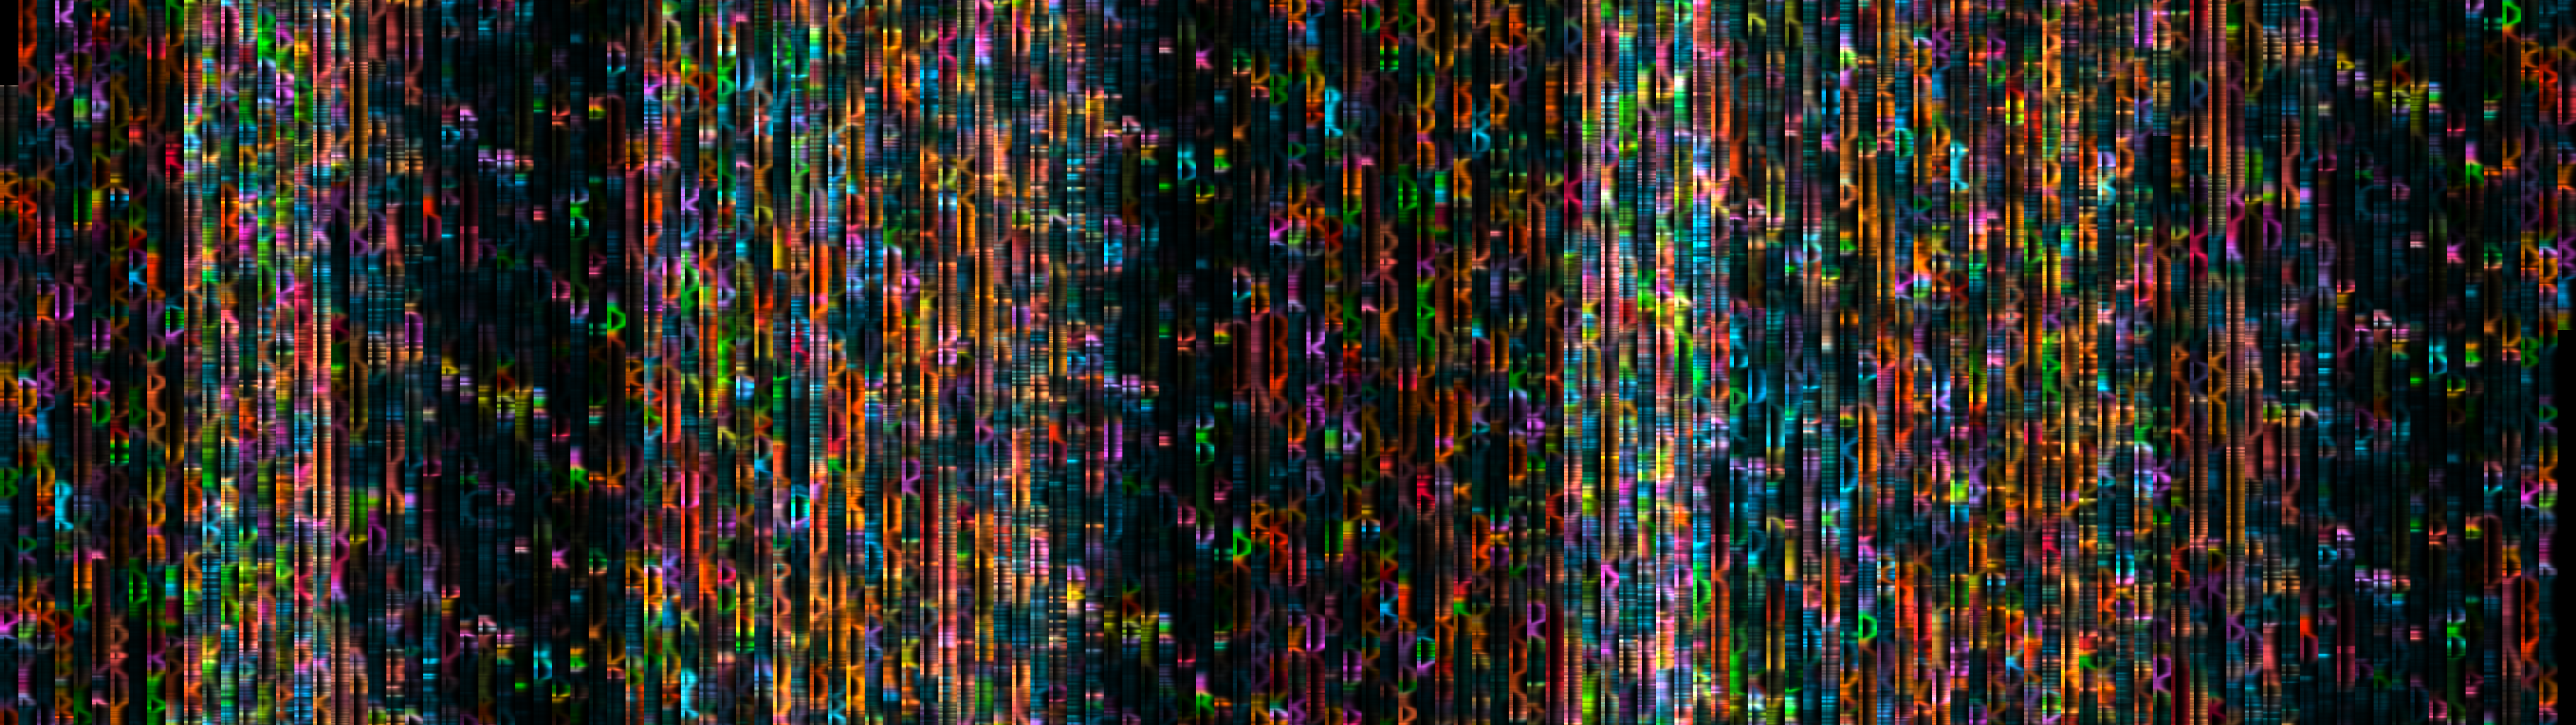

In [77]:
stacked = np.hstack(img.reshape(-1, cols, n_lights, 3))
imshow(stacked)